In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

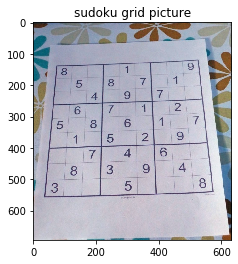

In [2]:
# Load an color image in grayscale
img = cv2.imread('images/picture_2.jpeg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

plt.imshow(img)
plt.title('sudoku grid picture')
plt.show()

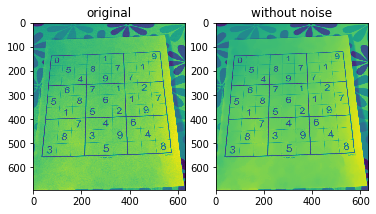

In [3]:
denoised_img = cv2.fastNlMeansDenoising(gray)

plt.subplot(121),plt.imshow(gray)
plt.title('original')
plt.subplot(122),plt.imshow(denoised_img)
plt.title('without noise')
plt.show()

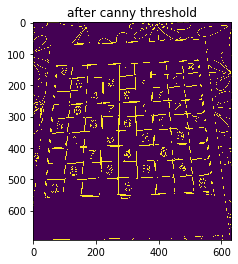

In [4]:
edges = cv2.Canny(denoised_img,10,150,apertureSize = 3)

plt.imshow(edges)
plt.title('after canny threshold')
plt.show()

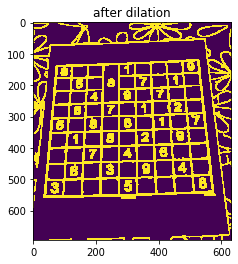

In [5]:
kernel = np.ones((3,3),np.uint8)
dilation = cv2.dilate(edges,kernel,iterations = 2)

plt.imshow(dilation)
plt.title('after dilation')
plt.show()

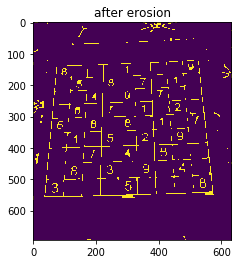

In [6]:
kernel = np.ones((7,7),np.uint8)
erosion = cv2.erode(dilation,kernel,iterations = 1)

plt.imshow(erosion)
plt.title('after erosion')
plt.show()

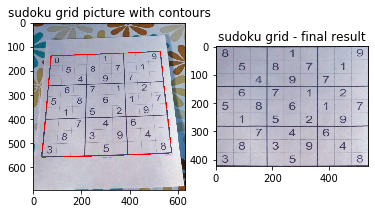

In [7]:
class SudokuGrid:
    
    def __init__(self, filepath):
        self.img = cv2.imread(filepath)
        self.gray = cv2.cvtColor(self.img,cv2.COLOR_BGR2GRAY)
        self.full_res_grid = None
        
    def find_edges(self):
        denoised_img = cv2.fastNlMeansDenoising(self.gray)
        return cv2.Canny(denoised_img,10,150,apertureSize = 3)
        
    def find_contours(self, edges):
        contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        biggest_contour = None
        biggest_contour_area = -1

        for contour in contours:
            contourArea = cv2.contourArea(contour)
            if contourArea > biggest_contour_area:
                biggest_contour_area = contourArea
                biggest_contour = contour
        
        if biggest_contour is not None:
            return biggest_contour, hierarchy
        
        return None
    
    def find_vertices(self, contours):
        # approximation of the grid shape
        epsilon = 0.1 * cv2.arcLength(contours, True)
        approx = cv2.approxPolyDP(contours,epsilon,True)
        
        pts = approx.reshape(4, 2)
        rect = np.zeros((4, 2), dtype = "float32")
        
        # the top-left point has the smallest sum whereas the
        # bottom-right has the largest sum
        s = pts.sum(axis = 1)
        
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        
        # compute the difference between the points 
        # the top-right will have the minumum difference and
        # the bottom-left will have the maximum difference
        diff = np.diff(pts, axis = 1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        
        return rect
    
    def warp(self, contours):
        vertices = self.find_vertices(contours)
        
        (top_left, top_right, bottom_right, bottom_left) = vertices
        
        # distance between the bottom right / bottom left points and top right / top left points
        widthA = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
        widthB = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
        
        # distance between the top right / bottom right points and top left / bottom left points
        heightA = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
        heightB = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))
        
        maxWidth = max(int(widthA), int(widthB))
        maxHeight = max(int(heightA), int(heightB))
        
        warped_vertices = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype = "float32")
        
        M = cv2.getPerspectiveTransform(vertices, warped_vertices)
        warped = cv2.warpPerspective(self.img, M, (maxWidth, maxHeight))
        
        return warped
    
    def generate_full_res(self):
        
        edges = self.find_edges()
        contours, hierarchy = self.find_contours(edges)
        
        self.full_res_grid = self.warp(contours)
        
        cv2.drawContours(self.img, [contours], 0, (255, 0, 0), 2, cv2.LINE_8, hierarchy, 0)
        
        return self.full_res_grid
    
    def get_array(self, saveToFile=False):
        if self.full_res_grid is None:
            return
        
        box_width = int(self.full_res_grid.shape[1] / 9)
        box_height = int(self.full_res_grid.shape[0] / 9)
        
        array = []
        
        for i in range(9):
            array.append([])
            for j in range(9):
                x = j * box_width
                y = i * box_height
                cropped = self.full_res_grid[y:y+box_height, x:x+box_width]
                array[i].append(cropped)
                if saveToFile:
                    cv2.imwrite('images/result_{}_{}.jpg'.format(i,j), cropped)
        
        return array


sudoku_grid = SudokuGrid('images/picture_2.jpeg')

res = sudoku_grid.generate_full_res()

cv2.imwrite('images/result_0.jpg',sudoku_grid.img)
cv2.imwrite('images/result_1.jpg',res)

plt.subplot(121), plt.imshow(sudoku_grid.img)
plt.title('sudoku grid picture with contours')
plt.subplot(122), plt.imshow(res)
plt.title('sudoku grid - final result')
plt.show()